## This is a test file to check validity of raw data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client, Variable
%matplotlib inline

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")

In [5]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu', cmap_sequential='Blues')

In [14]:
# Getting the data

# client = Client()

mfdataDIR1 = './data/GPM_data/gpm_2000/3B-HHR.MS.MRG.3IMERG.*.V06B.HDF5.nc4'

ds1 = xr.open_mfdataset(mfdataDIR1, engine = 'netcdf4', combine = 'nested', concat_dim='time', parallel=True) # this is GPM IMERG data

In [21]:
ds1 = ds1.drop_dims(['lonv', 'latv', 'nv'])
ds1 = ds1.transpose('time', 'lat', 'lon')

In [23]:
ds1

<xarray.Dataset>
Dimensions:             (time: 10272, lon: 401, lat: 401)
Coordinates:
  * lat                 (lat) float32 -0.05 0.05 0.15 0.25 ... 39.75 39.85 39.95
  * lon                 (lon) float32 60.05 60.15 60.25 ... 99.85 99.95 100.1
  * time                (time) object 2000-06-01 00:00:00 ... 2000-12-31 23:3...
Data variables:
    precipitationCal    (time, lat, lon) float32 dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
    precipitationUncal  (time, lat, lon) float32 dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
    IRprecipitation     (time, lat, lon) float32 dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2021-10-05 08:09:52 GMT Hyrax-1.16.3 htt...

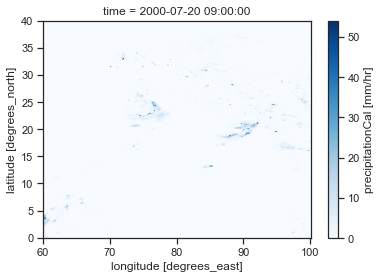

In [25]:
ds1.precipitationCal.sel(time = "2000-07-20 09:00:00").plot()